# Dueling DQN
This notebook tests the implementation of a Dueling Deep Q-Network. The network specifics are actually entirely encapsulated in the network file and NetworkBuilder class; otherwise, it is simply an instance of DQNetwork and supervised by a Double DQN (DDQN) agent.

## Initial setup

In [1]:
import sys
sys.path.insert(0, "../python")

In [2]:
from vizdoom import *
from helper import create_agent
import tensorflow as tf
%load_ext autoreload
%autoreload 2

In [3]:
# If running other experiments on GPUs
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Create agent

In [4]:
# Initializes DoomGame from config file
def initialize_vizdoom(config_file):
    game = DoomGame()
    game.load_config(config_file)
    game.init()
    return game  

In [15]:
# Initialize agent and TensorFlow graph
def make_new_agent():
    tf.reset_default_graph()
    agent_file_path = "./dueling_dqn/duelingdqn.json"
    config_file_path = "./dueling_dqn/duelingdqn.cfg"
    results_dir = "./dueling_dqn/results_dir"
    action_set = "basic_three"
    game = initialize_vizdoom(config_file_path)
    return create_agent(agent_file_path,
                        game=game, 
                        action_set=action_set,
                        output_directory=results_dir)

## Network file
Here is a view of the network file to which the agent file points.

In [ ]:
{
    "global_features": {
        "type": "DQN",
        "input_layer": "state",
        "output_layer": ["V", "pi"],
        "loss": ["huber", 1.0],
        "optimizer": ["rmsprop"]
    },
    
    "placeholders": [
        {
            "name": "state",
            "data_type": "float32",
            "kwargs": {
                "shape": [84, 84],
                "name": "state"
            }
        }
    ],

    "layers": [
        {
            "name": "CONV_1",
            "type": "conv2d",
            "input": "state",
            "kwargs": {
                "scope": "CONV_1",
                "num_outputs": 32, 
                "kernel_size": [8, 8],
                "stride": [4, 4],
                "padding": "VALID",
                "activation_fn": "relu",
                "weights_initializer": ["random_normal", "0", "0.1"], 
                "biases_initializer": ["constant", "0.1"]
            }
        },

        {
            "name": "CONV_2",
            "type": "conv2d",
            "input": "CONV_1",
            "kwargs": {
                "scope": "CONV_2",
                "num_outputs": 64, 
                "kernel_size": [4, 4],
                "stride": [2, 2],
                "padding": "VALID",
                "activation_fn": "relu",
                "weights_initializer": ["random_normal", "0", "0.1"], 
                "biases_initializer": ["constant", "0.1"]
            }
        },

        {
            "name": "CONV_2_FLAT",
            "type": "flatten",
            "input": "CONV_2",
            "kwargs": {
                "scope": "CONV_2_FLAT"
            }
        },

        {
            "name": "FC_1",
            "type": "fully_connected",
            "input": "CONV_2_FLAT",
            "kwargs": {
                "scope": "FC_1",        
                "num_outputs": 128,
                "activation_fn": "relu",
                "weights_initializer": ["random_normal", "0", "0.1"], 
                "biases_initializer": ["constant", "0.1"]
            }
        },

        {
            "name": "V",
            "type": "fully_connected",
            "input": "FC_1",
            "kwargs": {
                "scope": "V",        
                "num_outputs": 128,
                "activation_fn": "relu",
                "weights_initializer": ["random_normal", "0", "0.1"], 
                "biases_initializer": ["constant", "0.1"]
            }
        },

        {
            "name": "FC_2",
            "type": "fully_connected",
            "input": "CONV_2_FLAT",
            "kwargs": {
                "scope": "FC_2",        
                "num_outputs": 128,
                "activation_fn": "relu",
                "weights_initializer": ["random_normal", "0", "0.1"], 
                "biases_initializer": ["constant", "0.1"]
            }
        },

        {
            "name": "A",
            "type": "fully_connected",
            "input": "FC_2",
            "kwargs": {
                "scope": "A",        
                "num_outputs": 128,
                "activation_fn": "relu",
                "weights_initializer": ["random_normal", "0", "0.1"], 
                "biases_initializer": ["constant", "0.1"]
            }
        }
    ],

    "ops": [
    ]
}

## Network viability
Let's run through some basic tests to ensure that we are actually building the network we are intending. First, does `perform_learning_step` hold up both before and after the replay memory start size has been exceeded?

In [27]:
agent = make_new_agent()
agent.initialize_new_episode()
for i in range(1000):
    print("Step %d " % (i+1), end="\r")
    agent.perform_learning_step(1, 1)

Next, let's visualize the graph on Tensorboard. As you can see in the image shown below, the graph is pretty much as we expect: the state is processed by shared convolutional layers, which split into the **A** and **V** streams, which are then recombined to give **Q**.

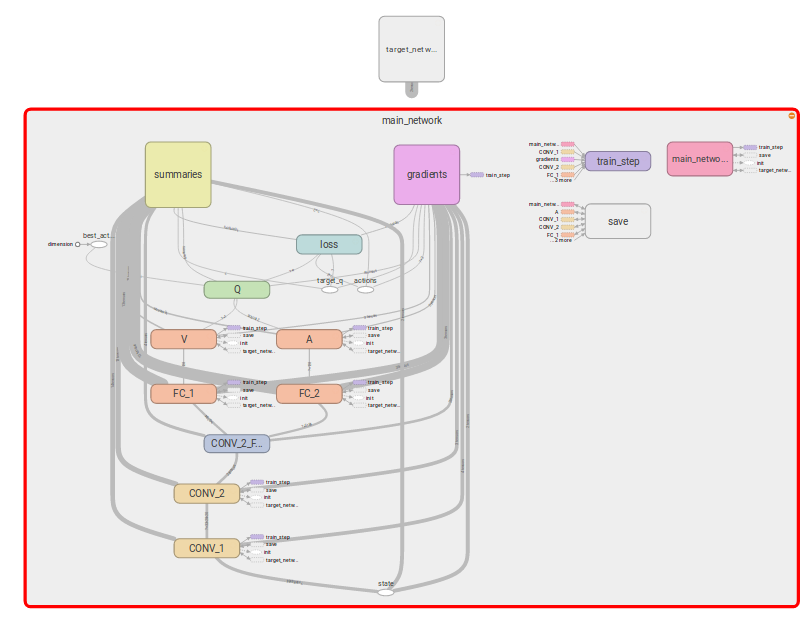

In [28]:
from IPython.display import Image
Image(filename='./dueling_dqn/tensorboard.png') 

## Gradient backpropagation
One of the new features in the implementation of a dueling network is gradient modification. In addition to using Huber loss to essentially clip gradients between [-1, 1] (as for DQN), we can tame gradients via two more ways. First, because the convolutional layers receive gradients from two streams, we will scale their gradients by $1/\sqrt{2}$. Additionally, we will also clip all gradients to an L2 norm of 10.

Let's select some states and rewards to serve as constants with which we will compare different gradient modifications.

In [135]:
# Load memory with transitions
agent = make_new_agent()
agent.initialize_new_episode()
for i in range(100):
    print("Step %d " % (i+1), end="\r")
    agent.perform_learning_step(1, 10)
    state = agent.network._check_state(agent.state)
    fd = {agent.network.state: state}
    #print(agent.network.get_q_values(agent.state))
    #print(agent.network.sess.run(agent.network.graph_dict["V"][0], feed_dict=fd))
    #print(agent.network.sess.run(agent.network.graph_dict["A"][0], feed_dict=fd))
    #print(agent.network.sess.run(agent.network.graph_dict["CONV_1"][0], feed_dict=fd))

# Save transition, parameters for comparison
s1, a, target_q, w = agent._get_learning_batch()
s1 = agent.network._check_state(s1)
a = agent.network._check_actions(a)
if w is None:
    w = np.ones(a.shape[0])
print("s1: ", s1[:, :3, 1, 1])
print("a:  ", a)
print("target Q:  ", target_q)
print("w:  ", w)
agent.save_model("test_model", save_summaries=False)

s1:  [[ 0.3642382   0.28103742  0.3642382 ]]
a:   [[0 0]]
target Q:   [ 14.44038677]
w:   [ 1.]
INFO:tensorflow:./dueling_dqn/results_dir/net_data/main_net/params/test_model is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:./dueling_dqn/results_dir/net_data/target_net/params/test_model is not in all_model_checkpoint_paths. Manually adding it.


The first network has no gradient modifications (see network file above). Let's compute its gradients on this test transition.

In [136]:
import numpy as np

In [137]:
def print_gradients():
    opt = agent.network.optimizer
    var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                 scope=agent.network.scope)
    fd = {agent.network.state: s1, agent.network.actions: a, 
          agent.network.target_q: target_q, agent.network.IS_weights: w}
    sess = agent.network.sess
    print("Q: ", sess.run(agent.network.q, feed_dict=fd))
    loss = sess.run(agent.network.loss, feed_dict=fd)
    print("target Q:  ", target_q)
    print("loss: ", loss)
    print("\ngradients: ")
    gvs = opt.compute_gradients(agent.network.loss, var_list=var_list)
    grads = sess.run([g for g, v in gvs], feed_dict=fd)
    for i, g in enumerate(grads):
        print(gvs[i][1].name[:-2])
        print(np.asarray(g).flatten()[:5]) 

In [138]:
print_gradients()

Q:  [[ 15.30836487   6.3911972   12.96953201]]
target Q:   [ 14.44038677]
loss:  [ 0.37669298]

gradients: 
main_network/CONV_1/weights
[ 0.64471304  0.         -0.01041097  0.85524201 -0.45281851]
main_network/CONV_1/biases
[ 1.40454459  0.         -0.00563607  2.44616389 -0.50368559]
main_network/CONV_2/weights
[ 0.63715118  0.68488252 -1.27361476 -0.08092929  0.        ]
main_network/CONV_2/biases
[ 0.29456395  0.53060681 -0.88705337 -0.06830859  0.        ]
main_network/FC_1/weights
[ 0.          0.03087017  0.03043333  0.0007776   0.00209546]
main_network/FC_1/biases
[ 0.          0.15993048  0.15766735  0.00402857  0.01085603]
main_network/V/weights
[  0.           6.56298637  11.41678047   0.73325318   1.51283872]
main_network/V/biases
[ 0.8679781]
main_network/FC_2/weights
[ 0.00658152  0.01192629  0.         -0.00855261 -0.01193598]
main_network/FC_2/biases
[ 0.0340972   0.06178709  0.         -0.04430889 -0.06183725]
main_network/A/weights
[ 2.74763107 -1.37381566 -1.37381566

In [142]:
# Create new agent with new gradient modulation and load parameters
agent = make_new_agent()
agent.initialize_new_episode()
agent.network.saver.restore(sess, "./dueling_dqn/results_dir/net_data/target_net/params/test_model")
print_gradients()

INFO:tensorflow:Restoring parameters from ./dueling_dqn/results_dir/net_data/target_net/params/test_model
Q:  [[  0.0667392    7.72957039 -10.62725163]]
target Q:   [ 14.44038677]
loss:  [ 13.87364769]

gradients: 
main_network/CONV_1/weights
[-1.09287858  0.63659602  0.          0.          0.91163081]
main_network/CONV_1/biases
[-2.51556945  1.66046262  0.          0.          2.12781858]
main_network/CONV_2/weights
[ 0.         -0.03377845  0.05168448  0.         -0.02843455]
main_network/CONV_2/biases
[ 0.         -0.39892423  0.15291639  0.         -0.14957863]
main_network/FC_1/weights
[ 0.  0.  0. -0. -0.]
main_network/FC_1/biases
[ 0.          0.          0.00657761 -0.0608688  -0.07199702]
main_network/V/weights
[ 0.          0.         -0.04801748 -0.6113801  -3.96216917]
main_network/V/biases
[-1.]
main_network/FC_2/weights
[ 0.  0.  0.  0. -0.]
main_network/FC_2/biases
[ 0.01712539  0.          0.          0.         -0.0224795 ]
main_network/A/weights
[-6.99790001  3.49895